<a href="https://colab.research.google.com/github/inahre/sketch_to_reality/blob/main/backdrop_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title installs

!pip install diffusers
!pip install Pillow
!pip install transformers
!pip install -qq accelerate
!pip install -qq "ipywidgets>=7,<8"
!pip install -qq bitsandbytes
!pip install huggingface_hub
!pip install pandas

In [ ]:
#@title imports

import PIL
import os
from PIL import Image, ImageOps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from diffusers import DiffusionPipeline

from google.colab import drive

from argparse import Namespace
import itertools
import math
from contextlib import nullcontext
import random

import torch.nn.functional as F
import torch.utils.checkpoint
import bitsandbytes as bnb

from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, DiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer


#from https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing#scrollTo=zywt5VQ30O3i

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
#@title mount google drive

drive.mount('/content/gdrive') #to get access to google drive content

Mounted at /content/gdrive


In [ ]:
#@title Backdrop Training

backdrop_model_name = "stablediffusionapi/realistic-vision-v51"

#this model works very well for photorealistic fashion and models

#source: https://huggingface.co/stablediffusionapi/realistic-vision-v51

In [ ]:
#@title # Load pre-trained model components for fine-tuning on the backdrop dataset
text_encoder = CLIPTextModel.from_pretrained(
    backdrop_model_name, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    backdrop_model_name, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    backdrop_model_name, subfolder="unet"
)
tokenizer = CLIPTokenizer.from_pretrained(
    backdrop_model_name, subfolder="tokenizer",
)

In [ ]:
#title define backdrop path

backdrop_path = "/content/gdrive/MyDrive/Thesis_Project/data/backdrops/"

backdrop_csv = "/content/gdrive/MyDrive/Thesis_Project/data/backdrop_descriptions.csv"


In [ ]:
# define path to your CSV file and the folder containing the images
csv_path = '/content/gdrive/MyDrive/Thesis_Project/data/backdrop_descriptions.csv'
images_path = '/content/gdrive/MyDrive/Thesis_Project/data/backdrops/'

# load CSV file into a DataFrame
df = pd.read_csv(csv_path)

#update paths in the 'image_path' column
df['backdrop_path'] = df['backdrop_path'].apply(lambda x: os.path.join(images_path, x))

# save updated DataFrame back to CSV file
df.to_csv(csv_path, index=False)


In [ ]:
#@title Captioned Backdrop Training

#Training Set-Up for Backdrops

#chose unique identifier for thesis
instance_prompt = "TR-GE textures and lighting" #@param {type:"string"}

prior_preservation = False

In [ ]:
#Setup prompt functions
#again, source is https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing#scrollTo=-vTl3__Qzt2V

from pathlib import Path
from torchvision import transforms

class Backdrop(Dataset): #added csv file for captioned training
    def __init__(
        self,
        backdrop_csv,
        image_dir,
        tokenizer,
        instance_prompt,
        size=512,
        center_crop=False,

    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer
        self.instance_prompt = instance_prompt

        # Load the CSV file containing image paths and descriptions
        self.data_frame = pd.read_csv(backdrop_csv)

        # Ensure the images directory exists
        self.image_dir = Path(backdrop_path)
        if not self.image_dir.exists():
            raise ValueError("Image directory doesn't exist.")

        # Create a list of image paths from the CSV file
        self.image_paths = [self.image_dir / img_name for img_name in self.data_frame['backdrop_path']]
        self.descriptions = self.data_frame['backdrop_description']
        self._length = len(self.image_paths)


        # Define image transformations
        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        image = Image.open(img_path).convert("RGB")
        image = self.image_transforms(image)

        description = self.descriptions.iloc[index]
        prompt_ids = self.tokenizer(
            description,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids


        return {'image': image, 'prompt_ids': prompt_ids, 'instance_prompt': self.instance_prompt}

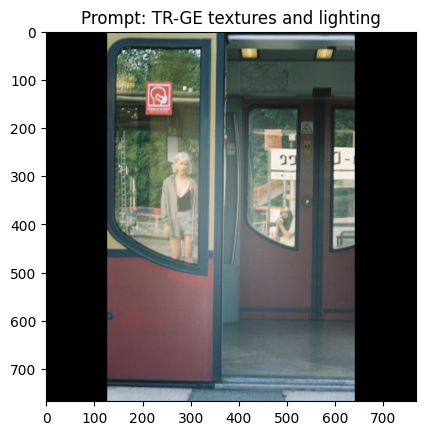

Description: A reflection in the train door reveals a person waiting outside, bathed in warm afternoon light that creates a sense of anticipation.


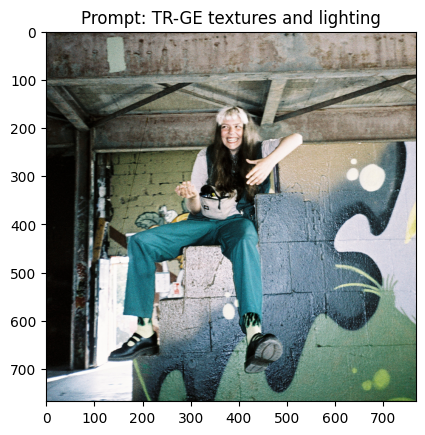

Description: An industrial space with vibrant graffiti serves as a playful backdrop, where a person casually sits on a concrete block, illuminated by soft, diffused light.


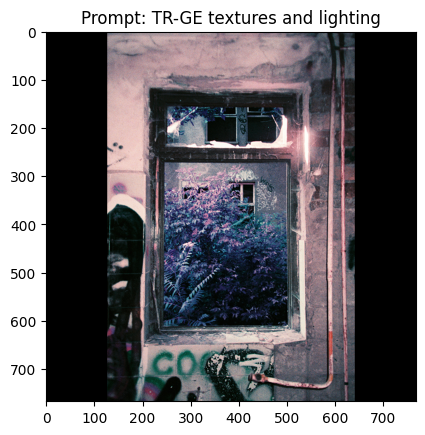

Description: A framed view through a broken window shows overgrown foliage, illuminated by soft, filtered light that creates a serene and dreamy atmosphere. Purple hues.


In [ ]:
#check if images and descriptions set up correctly
backdrop_csv = backdrop_csv
image_dir = backdrop_path
instance_prompt = instance_prompt

# dataset
dataset = Backdrop(
    backdrop_csv=backdrop_csv,
    image_dir=image_dir,
    tokenizer=tokenizer,
    instance_prompt=instance_prompt,
    size=768,
    center_crop=True
)

# Load a few samples
for i in range(3):  # Test with first 3 images
    sample = dataset[i]

    # Display image
    img = sample['image'].permute(1, 2, 0).numpy()  # Convert to HWC format for display
    img = (img * 0.5) + 0.5  #undo normalization
    plt.imshow(img)
    plt.title(f"Prompt: {sample['instance_prompt']}")
    plt.show()

    # Print description
    print(f"Description: {dataset.descriptions.iloc[i]}")

In [ ]:
#Setting up training arguments as by https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing#scrollTo=-vTl3__Qzt2V

#adjusted hyperparameters for use case
from argparse import Namespace
args = Namespace(
    model_name=backdrop_model_name,
    resolution=768,
    center_crop=False, #images already preprocessed with Adobe Photoshop
    instance_data_dir=backdrop_path,
    instance_prompt=instance_prompt,
    learning_rate=5e-7,
    max_train_steps=1200,
    #already trained with 1200 steps, adding another 1200 to optimise results
    save_steps=200,
    train_batch_size=3,
    gradient_accumulation_steps=2,
    #higher batch size is more relevant for style transfer, but also leads to overfitting
    max_grad_norm=1.0,
    mixed_precision="fp16", # set to "fp16" for mixed-precision training.
    gradient_checkpointing=True, # set this to True to lower the memory usage.
    use_8bit_adam=True, # use 8bit optimizer from bitsandbytes
    seed=3434554,
    with_prior_preservation=prior_preservation,
    #removed class variables
    lr_scheduler="constant",
    lr_warmup_steps=0,
    output_dir="/content/gdrive/MyDrive/Thesis_Project/backdrops_checkpoints_refined",
)

In [ ]:
#training function adapted from https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing#scrollTo=-vTl3__Qzt2V and modified
from accelerate.utils import set_seed

def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    set_seed(args.seed)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
    )

    # Currently, it's not possible to do gradient accumulation when training two models with accelerate.accumulate
    # This will be enabled soon in accelerate. For now, we don't allow gradient accumulation when training two models.
    # TODO (patil-suraj): Remove this check when gradient accumulation with two models is enabled in accelerate.
    if args.train_text_encoder and args.gradient_accumulation_steps > 1 and accelerator.num_processes > 1:
        raise ValueError(
            "Gradient accumulation is not supported when training the text encoder in distributed training. "
            "Please set gradient_accumulation_steps to 1. This feature will be supported in the future."
        )

    vae.requires_grad_(False)
    if not args.train_text_encoder:
        text_encoder.requires_grad_(False)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        if args.train_text_encoder:
            text_encoder.gradient_checkpointing_enable()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    params_to_optimize = (
        itertools.chain(unet.parameters(), text_encoder.parameters()) if args.train_text_encoder else unet.parameters()
    )

    optimizer = optimizer_class(
        params_to_optimize,
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler.from_config(args.model_name, subfolder="scheduler")

    train_dataset = Backdrop( #replaced with prompt function relevant to current use case
        backdrop_csv = backdrop_csv,
        image_dir=backdrop_path,
        instance_prompt=args.instance_prompt,
        tokenizer=tokenizer,
        size=args.resolution,
        center_crop=args.center_crop,
    )

    def collate_fn(examples):
        input_ids = [example["prompt_ids"] for example in examples]
        pixel_values = [example["image"] for example in examples]

        pixel_values = torch.stack(pixel_values)
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

        input_ids = tokenizer.pad(
            {"input_ids": input_ids},
            padding="max_length",
            return_tensors="pt",
            max_length=tokenizer.model_max_length
        ).input_ids

        batch = {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
        }
        return batch

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn
    )

    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
        num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
    )

    if args.train_text_encoder:
        unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, text_encoder, optimizer, train_dataloader, lr_scheduler
        )
    else:
        unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, optimizer, train_dataloader, lr_scheduler
        )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move text_encode and vae to gpu.
    # For mixed precision training we cast the text_encoder and vae weights to half-precision
    # as these models are only used for inference, keeping weights in full precision is not required.
    vae.to(accelerator.device, dtype=weight_dtype)
    vae.decoder.to("cuda")
    if not args.train_text_encoder:
        text_encoder.to(accelerator.device, dtype=weight_dtype)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                loss = F.mse_loss(noise_pred.float(), target.float(), reduction="mean")
                accelerator.backward(loss)


                if accelerator.sync_gradients:
                    params_to_clip = (
                        itertools.chain(unet.parameters(), text_encoder.parameters())
                        if args.train_text_encoder
                        else unet.parameters()
                    )
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

                if global_step % args.save_steps == 0:
                    if accelerator.is_main_process:
                        pipeline = DiffusionPipeline.from_pretrained(
                            args.model_name,
                            unet=accelerator.unwrap_model(unet),
                            text_encoder=accelerator.unwrap_model(text_encoder),
                        )
                        save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                        pipeline.save_pretrained(save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = DiffusionPipeline.from_pretrained(
            args.model_name,
            unet=accelerator.unwrap_model(unet),
            text_encoder=accelerator.unwrap_model(text_encoder),
        )
        pipeline.save_pretrained(args.output_dir)

In [ ]:
#Run the Training Job as adapted by https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing#scrollTo=zywt5VQ30O3i
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))
for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

In [ ]:
model_path = "/content/gdrive/MyDrive/Thesis_Project/backdrops_checkpoints_refined/checkpoint-1200"
pipe = DiffusionPipeline.from_pretrained(model_path)

  0%|          | 0/25 [00:00<?, ?it/s]

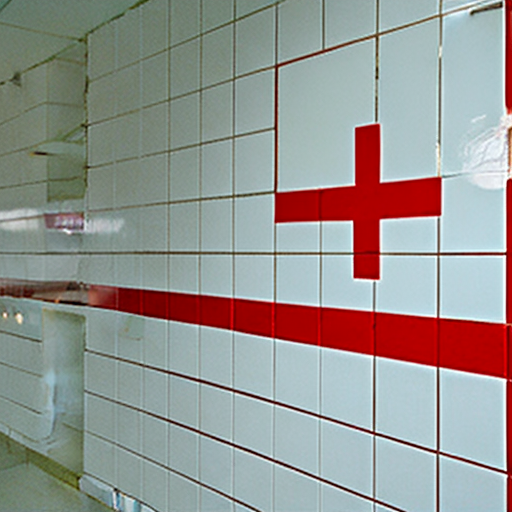

In [ ]:
#Run the Stable Diffusion pipeline on Colab
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "White tiled room with a red cross on the far wall." #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = []
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=25, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

In [ ]:
#@title Uncaptioned Backdrop Training

backdrop_model_name = "stablediffusionapi/realistic-vision-v51"

In [ ]:
#redefine backdrop path

backdrop_path = "/content/gdrive/MyDrive/Thesis_Project/data/backdrops/"

In [ ]:
#title Set up and run uncaptioned training
#https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing#scrollTo=-vTl3__Qzt2V
#parts adjusted to fit the use case

from pathlib import Path
from torchvision import transforms

class RV_Textures_Lighting(Dataset): #omit csv file here
    def __init__(
        self,
        image_dir,
        tokenizer,
        instance_prompt,
        size=768,
        center_crop=False,
        #removed class_data_root and class_prompt, as not working with object classes

    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer
        self.instance_prompt = instance_prompt

        # Ensure the images directory exists
        self.image_dir = Path(backdrop_path)
        if not self.image_dir.exists():
            raise ValueError("Image directory doesn't exist.")

        # Create a list of image paths from the image directory
        self.image_paths = list(self.image_dir.glob("*"))
        self._length = len(self.image_paths)

        # Tokenize the constant instance prompt just once
        self.prompt_ids = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        # Define image transformations
        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        image = Image.open(img_path).convert("RGB")
        image = self.image_transforms(image)

        return {'image': image,'instance_prompt': self.instance_prompt}

In [ ]:
#one more time, https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing#scrollTo=-vTl3__Qzt2V

#adjusted hyperparameters
from argparse import Namespace
args = Namespace(
    model_name=backdrop_model_name,
    resolution=768,
    center_crop=False, #using same data as before, had already been pre-processed
    train_text_encoder=False,
    instance_data_dir=backdrop_path,
    instance_prompt=instance_prompt,
    learning_rate=1e-6,
    max_train_steps=2400, #set to 2400 because captioned training resulted in good outcomes at this checkpoint
    save_steps=200,
    train_batch_size=3,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    mixed_precision="fp16", # set to "fp16" for mixed-precision training.
    gradient_checkpointing=True, # set this to True to lower the memory usage.
    use_8bit_adam=True, # use 8bit optimizer from bitsandbytes
    seed=3434554,
    with_prior_preservation=prior_preservation,
    lr_scheduler="constant",
    lr_warmup_steps=0,
)

In [ ]:
#from https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing#scrollTo=-vTl3__Qzt2V and modified
from accelerate.utils import set_seed

# Tokenize the constant instance prompt once outside the function
constant_prompt_ids = tokenizer(
    args.instance_prompt,
    padding="do_not_pad",
    truncation=True,
    max_length=tokenizer.model_max_length,
).input_ids

def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    set_seed(args.seed)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
    )

    # Currently, it's not possible to do gradient accumulation when training two models with accelerate.accumulate
    # This will be enabled soon in accelerate. For now, we don't allow gradient accumulation when training two models.
    # TODO (patil-suraj): Remove this check when gradient accumulation with two models is enabled in accelerate.
    if args.train_text_encoder and args.gradient_accumulation_steps > 1 and accelerator.num_processes > 1:
        raise ValueError(
            "Gradient accumulation is not supported when training the text encoder in distributed training. "
            "Please set gradient_accumulation_steps to 1. This feature will be supported in the future."
        )

    vae.requires_grad_(False)
    if not args.train_text_encoder:
        text_encoder.requires_grad_(False)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        if args.train_text_encoder:
            text_encoder.gradient_checkpointing_enable()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    params_to_optimize = (
        itertools.chain(unet.parameters(), text_encoder.parameters()) if args.train_text_encoder else unet.parameters()
    )

    optimizer = optimizer_class(
        params_to_optimize,
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler.from_config(args.model_name, subfolder="scheduler")

    train_dataset = RV_Textures_Lighting( #replaced with prompt function relevant to current use case
        image_dir=backdrop_path,
        instance_prompt=args.instance_prompt,
        tokenizer=tokenizer,
        size=args.resolution,
        center_crop=args.center_crop,
    )

    def collate_fn(examples):
        pixel_values = [example["image"] for example in examples]

        #removed if-function for prior preservation

        pixel_values = torch.stack(pixel_values)
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

        # Use constant_prompt_ids as input_ids for all examples
        input_ids = torch.tensor([constant_prompt_ids] * len(pixel_values))

        batch = {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
        }
        return batch

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn
    )

    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
        num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
    )

    if args.train_text_encoder:
        unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, text_encoder, optimizer, train_dataloader, lr_scheduler
        )
    else:
        unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, optimizer, train_dataloader, lr_scheduler
        )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move text_encode and vae to gpu.
    # For mixed precision training we cast the text_encoder and vae weights to half-precision
    # as these models are only used for inference, keeping weights in full precision is not required.
    vae.to(accelerator.device, dtype=weight_dtype)
    vae.decoder.to("cuda")
    if not args.train_text_encoder:
        text_encoder.to(accelerator.device, dtype=weight_dtype)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                loss = F.mse_loss(noise_pred.float(), target.float(), reduction="mean")
                accelerator.backward(loss)


                if accelerator.sync_gradients:
                    params_to_clip = (
                        itertools.chain(unet.parameters(), text_encoder.parameters())
                        if args.train_text_encoder
                        else unet.parameters()
                    )
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

                if global_step % args.save_steps == 0:
                    if accelerator.is_main_process:
                        pipeline = DiffusionPipeline.from_pretrained(
                            args.model_name,
                            unet=accelerator.unwrap_model(unet),
                            text_encoder=accelerator.unwrap_model(text_encoder),
                        )
                        save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                        pipeline.save_pretrained(save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = DiffusionPipeline.from_pretrained(
            args.model_name,
            unet=accelerator.unwrap_model(unet),
            text_encoder=accelerator.unwrap_model(text_encoder),
        )
        pipeline.save_pretrained(args.output_dir)

In [ ]:
#Run the Training Job (directly adapted from https://colab.research.google.com/drive/1muBY-yFCu_jAxnxeNW0RGwwNQhWQsE24?usp=sharing#scrollTo=zywt5VQ30O3i)
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))
for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

In [ ]:
model_path = "/content/gdrive/MyDrive/Thesis_Project/RV_uncaptioned_checkpoints/checkpoint-2400"
pipe = DiffusionPipeline.from_pretrained(model_path)

  0%|          | 0/25 [00:00<?, ?it/s]

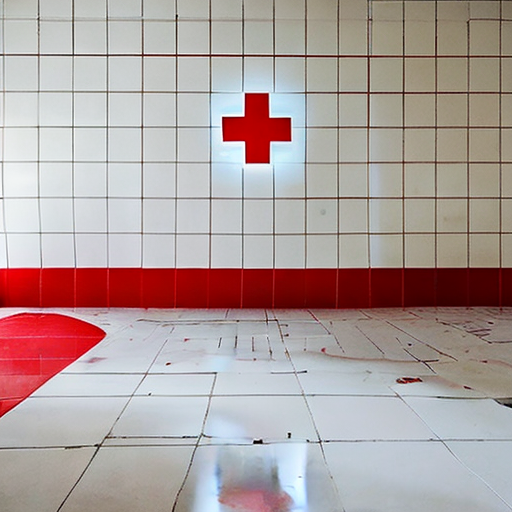

In [ ]:
#Run the Stable Diffusion pipeline on Colab
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "White tiled room with a red cross on the far wall." #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = []
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=25, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid